# Task 3 - Deferred Annuity

In [207]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

### Task 3.1 - Premium Calculation

#### Deriving the results using commutation numbers

In [135]:
x = 30
m = 65
it = 0.02
omega = 110
R_ann = 60000

v = 1/(1+it)

def Qx(x, gender=0, t0=2024):
    t = t0 + (x-30)
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def l(x):
    px = 1
    for i in range(x):
        px *= (1-Qx(i))
    return px

def D(x):
    return l(x)*v**x

def N(x):
    N = 0
    for i in range(x, omega):
        N += D(i)
    return N

def S(x):
    S = 0
    for i in range(x, omega):
        S += N(i)
    return S

def C(x):
    return (l(x)-l(x+1))*v**(x+1)

def M(x):
    M = 0
    for i in range(x, omega):
        M += C(i)
    return M

def R(x):
    R = 0
    for i in range(x, omega):
        R += M(i)
    return R

def prem(P):
    return P*(N(x)-N(m))/D(x)

def ann():
    return R_ann*N(m)/D(x)

def DB1(P):
    return P*(R(x)-R(m)-(m-x)*M(m))/D(x)

def DB2(P):
    n = int(np.floor((m-x)*P/R_ann))
    rem = (m-x)*P - n*R_ann
    return rem*(M(m)-M(m+n+1))/D(x) + R_ann*(n*M(m)-R(m+1)+R(m+n+1))/D(x)

def total(P):
    return ann() - prem(P) + DB1(P) + DB2(P)

print("The premium for this insurance is", round(fsolve(total, 20000)[0], 2))


/var/folders/c8/zqx7xbq149g5w64tvz0s5s2r0000gn/T/ipykernel_52802/2546533457.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(np.floor((m-x)*P/R_ann))


The premium for this insurance is 25646.58


#### Leveraging the code from the lecture - can be found [here](https://github.com/michaeldfkoller/lv12/blob/main/ATW.ipynb)

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def Qx(gender,x,t,param =[]):
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def LinearIncrease(x,param=[]):
    x0 = param[0]
    s = param[1]
    P = param[2]
    if (x >= s): return(0)
    return(P * (x-x0+1.))

def LinearDecrease(x,param=[]):
    x0= param[0]
    L0= param[1]
    DeltaL = -param[2]
    if (x<x0): return(0.)
    return(max(0,L0 + (x-x0)*DeltaL))

def DeferredAnnuity(x,param=[]):
    x0= param[0]
    if (x<x0): return(0.)
    return(1.)
    
def TempAnnuity(x,param=[]):
    x0= param[0]
    if (x<x0): return(1.)
    return(0.)

class Capital:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2024):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymM = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = self.psymM(s,param=param)
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
class Annuity:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2024):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = 0
        for i in range(s-1,x-1,-1):  # [109, 108, ..., 30]
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)  # prob of dying in [i, i+1]
            px = 1. - qx  # prob of surviving [i, i+1]
            PV = self.psymB(i,param=param) + px * self.dV * PV
        return(PV)

In [138]:
MyQx = Qx

x  = 30
s = 65
gender = 0
omega = 110
R = 60000

naex = Annuity(MyQx) 
IAxn = Capital(MyQx) 
mDAx = Capital(MyQx) 
axm = Annuity(MyQx)

naex.psymB = DeferredAnnuity
IAxn.psymB = LinearIncrease
IAxn.psymM = ZeroBenefit
mDAx.psymB = LinearDecrease
mDAx.psymM = ZeroBenefit
axm.psymB = TempAnnuity

def total(P, R=R):
    PVL = R*naex.CalcPV(gender,x,omega, param =[s])
    PVP1 = -P*axm.CalcPV(gender,x,omega, param =[s])
    PVP2 = P*IAxn.CalcPV(gender,x,omega,param=[x,s,1.])
    PVP3 = mDAx.CalcPV(gender,x,omega,param=[s,(s-x)*P, R])
    return PVL+PVP1+PVP2+PVP3

print("The premium for this insurance is", round(fsolve(total, 20000)[0], 2))

The premium for this insurance is 25646.58


#### Deriving the results using the Markov model

In [234]:
x = 30
t = 2024
m = 65
R = 60000
it = 0.02
w = 110

def Qx(x, t=t):
    t = t + (x-30)
    a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    return np.exp(a[0] + a[1]*x + a[2]*x**2 + a[3]*t)

def Pxt(x, t):
    Pxt = 1
    for i in range(x, t):
        Pxt *= 1-Qx(i)
    return Pxt

def premium(t, P, x=x, m=m, it=it):
    if t>=x and t<m:
        return -Pxt(x, t)*P/(1+it)**(t-x)
    else: return 0

def annuity(t, R=R, m=m, it=it, x=x):
    if t>=m:
        return R*Pxt(x, t)/(1+it)**(t-x)
    else: return 0

def death_benefit_1(t, P, R=R, x=x, m=m, it=it):
    if t>x and t<=m:
        return Pxt(x, t-1)*Qx(t-1)*P*(t-x)/(1+it)**(t-x)
    else: return 0

def death_benefit_2(t, P, R=R, x=x, m=m, it=it):
    if t>m:
        return max(Pxt(x, t-1)*Qx(t-1)*(P*(m-x)-R*(t-m-1))/(1+it)**(t-x), 0)
    else: return 0

def pv_policy(P, lrange=x, hrange=w):
    return sum([premium(t, P) + death_benefit_1(t, P) + death_benefit_2(t, P) + annuity(t) for t in range(lrange, hrange)])

P_ins = fsolve(pv_policy, 20000)[0]
print("The calculated premium is: ", round(P_ins, 2))


The calculated premium is:  25646.58


/Users/angeline/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


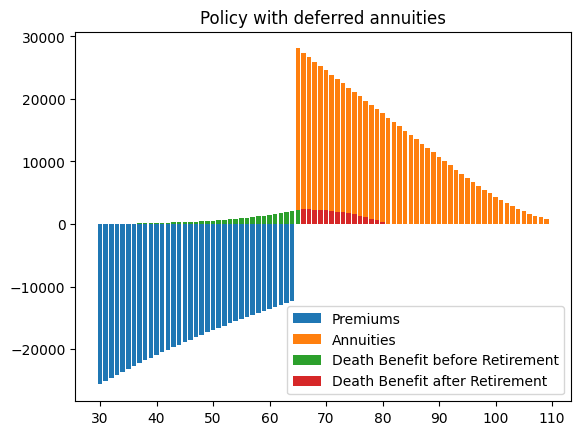

In [235]:
tmax = np.arange(x, 110, 1)
plt.bar(tmax, [premium(t, P_ins) for t in tmax], label='Premiums')
plt.bar(tmax, [annuity(t) for t in tmax], label='Annuities')
plt.bar(tmax, [death_benefit_1(t, P_ins) for t in tmax], label='Death Benefit before Retirement')
plt.bar(tmax, [death_benefit_2(t, P_ins) for t in tmax], label='Death Benefit after Retirement')
plt.title('Policy with deferred annuities')
plt.legend()
plt.show()

In [144]:
def premium_com_ann(P, lrange=x, hrange=110):
    return sum([premium(t, P) + annuity(t) for t in range(lrange, hrange)])
print("The annual premium for the annuity benefit is", round(fsolve(premium_com_ann, 10000)[0], 2))

def premium_com_db_1(P, lrange=x, hrange=110):
    return sum([premium(t, P) + death_benefit_1(t, P_ins) for t in range(lrange, hrange)])
print("The annual premium for the death benefit before retirement is", round(fsolve(premium_com_db_1, 10000)[0], 2))

def premium_com_db_2(P, lrange=x, hrange=110):
    return sum([premium(t, P) + death_benefit_2(t, P_ins) for t in range(lrange, hrange)])
print("The annual premium for the death benefit after retirement is", round(fsolve(premium_com_db_2, 10000)[0], 2))

The annual premium for the annuity benefit is 23695.72
The annual premium for the death benefit before retirement is 955.98
The annual premium for the death benefit after retirement is 994.89


### Task 3.2 - Mathematical Reserve

The mathematical reserve at age 30 is 0.0
The mathematical reserve at age 40 is 286716.53
The mathematical reserve at age 50 is 637593.27
The mathematical reserve at age 65 is 1330119.47
The mathematical reserve at age 70 is 1166216.63
The mathematical reserve at age 75 is 998993.59
The mathematical reserve at age 85 is 697854.61


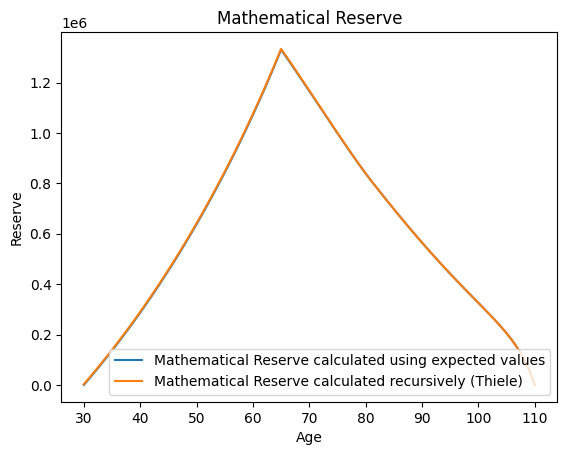

In [233]:
def Prem(k, P=P_ins, R=R):
    if k >= x and k < m:
        return -P
    elif k >= m:
        return R
    else: return 0

def C(k, P=P_ins, R=R):
    if k >= x and k <= m:
        return P*(k-x)
    elif k > m:
        return max(P*(m-x)-R*(k-m-1), 0)
    else: return 0

def mathematical_reserve(tr):
    reserve = 0
    for i in range(tr, 110):
        reserve += (Pxt(tr,i)*Prem(i) + Pxt(tr,i-1)*Qx(i-1)*C(i))/((1+it)**(i-tr))
    return reserve

def recursive_reserve(k):
    V = 0
    for i in range(109, k-1, -1):
        V = Prem(i) + (Qx(i)*C(i)+ (1-Qx(i))*V)/(1+it)
    return V

tr = [30, 40, 50, 65, 70, 75, 85]
for i in tr:
    print(f"The mathematical reserve at age {i} is {round(mathematical_reserve(i)+0.0000001, 2)}")

tr = np.arange(30, 111, 1)
plt.plot(tr, [mathematical_reserve(i) for i in tr], label='Mathematical Reserve calculated using expected values')
plt.plot(tr, [recursive_reserve(i) for i in tr], label='Mathematical Reserve calculated recursively (Thiele)')
plt.legend()
plt.title('Mathematical Reserve')
plt.xlabel('Age')
plt.ylabel('Reserve')
plt.show()

### Task 3.3 - Risk Premium by Type

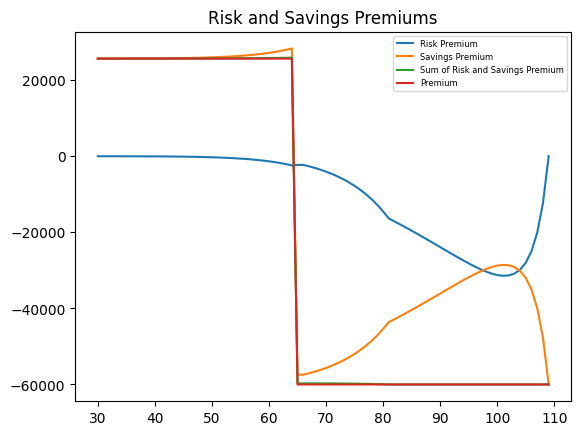

In [241]:
def risk_premium(x):
    return (C(x)-mathematical_reserve(x+1))*Qx(x)/(1+it)

def savings_premium(x):
    return -mathematical_reserve(x)+(mathematical_reserve(x+1)/(1+it))

age_range = np.arange(x, 110, 1)
plt.plot(age_range, [risk_premium(k) for k in age_range], label='Risk Premium')
plt.plot(age_range, [savings_premium(k) for k in age_range], label='Savings Premium')
plt.plot(age_range, [risk_premium(k)+savings_premium(k) for k in age_range], label='Sum of Risk and Savings Premium')
plt.plot(age_range, [-Prem(k) for k in age_range], label='Premium')
plt.title('Risk and Savings Premiums')
plt.legend(prop={'size': 6})
plt.show()

In [238]:
def Ann(k, R=R, P=P_ins):
    if k >= x and k < m:
        return -P
    if k >= m:
        return R
    else: return 0

def C1(k, P=P_ins, R=R):
    if k > x and k <= m:
        return P*(k-x)
    else:
        return 0
    
def C2(k, P=P_ins, R=R):
    if k > m:
        return max(P*(m-x)-R*(k-m-1), 0)
    else:
        return 0
    
def mathematical_reserve_type(tr, type):
    reserve = 0
    for i in range(tr, 110):
        if type == 'Ann':
            reserve += (Pxt(tr,i)*Ann(i))/((1+it)**(i-tr))
        elif type == 'C1':
            reserve += (Pxt(tr,i-1)*Qx(i-1)*C1(i))/((1+it)**(i-tr))
        elif type == 'C2':
            reserve += (Pxt(tr,i-1)*Qx(i-1)*C2(i))/((1+it)**(i-tr))
    return reserve
    
def savings_prem_type(x, type):
    return mathematical_reserve_type(x+1, type)/(1+it)-mathematical_reserve_type(x, type)

def risk_prem_type(x, type):
    if type == 'Ann':
        return -mathematical_reserve_type(x+1, type)*Qx(x)/(1+it)
    elif type == 'C1':
        return (C1(x)-mathematical_reserve_type(x+1, type))*Qx(x)/(1+it)
    elif type == 'C2':
        return (C2(x)-mathematical_reserve_type(x+1, type))*Qx(x)/(1+it)
    else: return 0

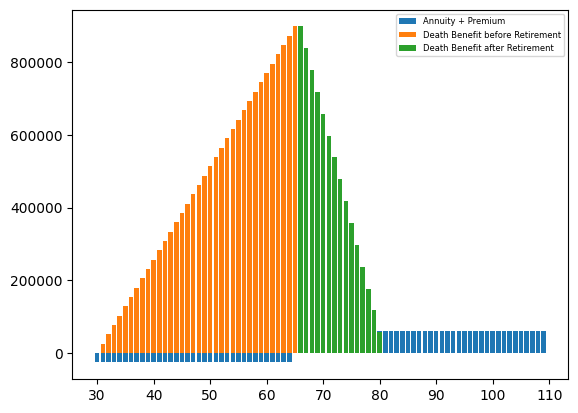

In [199]:
plt.bar(age_range, [Ann(k) for k in age_range], label='Annuity + Premium')
plt.bar(age_range, [C1(k) for k in age_range], label='Death Benefit before Retirement')
plt.bar(age_range, [C2(k) for k in age_range], label='Death Benefit after Retirement')
plt.legend(prop={'size': 6})
plt.show()

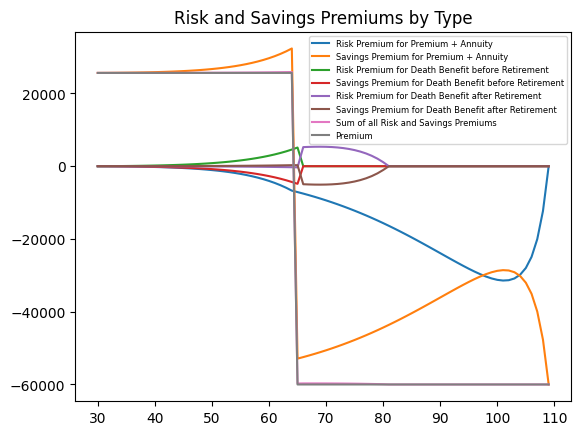

In [239]:
plt.plot(age_range, [risk_prem_type(k, 'Ann') for k in age_range], label='Risk Premium for Premium + Annuity')
plt.plot(age_range, [savings_prem_type(k, 'Ann') for k in age_range], label='Savings Premium for Premium + Annuity')
plt.plot(age_range, [risk_prem_type(k, 'C1') for k in age_range], label='Risk Premium for Death Benefit before Retirement')
plt.plot(age_range, [savings_prem_type(k, 'C1') for k in age_range], label='Savings Premium for Death Benefit before Retirement')
plt.plot(age_range, [risk_prem_type(k, 'C2') for k in age_range], label='Risk Premium for Death Benefit after Retirement')
plt.plot(age_range, [savings_prem_type(k, 'C2') for k in age_range], label='Savings Premium for Death Benefit after Retirement')
plt.plot(age_range, [risk_prem_type(k, 'Ann')+savings_prem_type(k, 'Ann')+risk_prem_type(k, 'C1')+savings_prem_type(k,'C1')+risk_prem_type(k, 'C2')+savings_prem_type(k,'C2') for k in age_range], label='Sum of all Risk and Savings Premiums')
plt.plot(age_range, [-Prem(k) for k in age_range], label='Premium')
plt.title('Risk and Savings Premiums by Type')
plt.legend(prop={'size': 6})
plt.show()

In [240]:
for k in [30, 40, 50, 65, 70, 75, 85]:
    print(f"The risk premium for the annuity benefit at age {k} is {round(risk_prem_type(k, 'Ann')+0.0000001, 0)}")
    print(f"The savings premium for the annuity benefit at age {k} is {round(savings_prem_type(k, 'Ann')+0.0000001, 0)}")
    print(f"The risk premium for the death benefit before retirement at age {k} is {round(risk_prem_type(k, 'C1')+0.0000001, 0)}")
    print(f"The savings premium for the death benefit before retirement at age {k} is {round(savings_prem_type(k, 'C1')+0.0000001, 0)}")
    print(f"The risk premium for the death benefit after retirement at age {k} is {round(risk_prem_type(k, 'C2')+0.0000001, 0)}")
    print(f"The savings premium for the death benefit after retirement at age {k} is {round(savings_prem_type(k, 'C2')+0.0000001, 0)}")
    print(f"The sum of all risk and savings premiums at age {k} is {round(risk_prem_type(k, 'Ann')+savings_prem_type(k, 'Ann')+risk_prem_type(k, 'C1')+savings_prem_type(k,'C1')+risk_prem_type(k, 'C2')+savings_prem_type(k,'C2')+0.0000001, 0)}")
    print(f"The sum of all risk premiums at age {k} is {round(risk_prem_type(k, 'Ann')+risk_prem_type(k, 'C1')+risk_prem_type(k, 'C2')+0.0000001, 0)}")
    print(f"The sum of all savings premiums at age {k} is {round(savings_prem_type(k, 'Ann')+savings_prem_type(k, 'C1')+savings_prem_type(k, 'C2')+0.0000001, 0)}")

The risk premium for the annuity benefit at age 30 is 9.0
The savings premium for the annuity benefit at age 30 is 25638.0
The risk premium for the death benefit before retirement at age 30 is -9.0
The savings premium for the death benefit before retirement at age 30 is 9.0
The risk premium for the death benefit after retirement at age 30 is -10.0
The savings premium for the death benefit after retirement at age 30 is 10.0
The sum of all risk and savings premiums at age 30 is 25647.0
The sum of all risk premiums at age 30 is -10.0
The sum of all savings premiums at age 30 is 25657.0
The risk premium for the annuity benefit at age 40 is -209.0
The savings premium for the annuity benefit at age 40 is 25856.0
The risk premium for the death benefit before retirement at age 40 is 184.0
The savings premium for the death benefit before retirement at age 40 is -173.0
The risk premium for the death benefit after retirement at age 40 is -25.0
The savings premium for the death benefit after retir